In [2]:
from typing import List, Dict
import numpy as np
import matplotlib.pyplot as plt

from PV_Generation import generate_PV_profile
from Load import generate_load_profile
from Price_Forecast import generate_price_profile
from Agents import Prosumer
from Market import match_trades, match_local_market
from Regulator import Regulator
from BlockChain import Blockchain


In [3]:
def run_simulation(
    num_prosumers: int = 200,
    num_steps: int = 24,
    activate_regulator: bool = True,
    regulator_objective: str = "maximize_p2p",
    block_chain_difficulty: int = 3,
    # -------- Battery settings (community battery) --------
    battery_capacity_kwh: float = 500.0,
    battery_soc_init_kwh: float = 0.0,
    battery_charge_eff: float = 0.95,
    battery_discharge_eff: float = 0.95,
) -> Dict:

    # ---------------- Initialization ----------------
    prosumers: List[Prosumer] = []
    for i in range(num_prosumers):
        has_pv = (i < int(0.7 * num_prosumers))
        prosumers.append(Prosumer(id=i, has_pv=has_pv))

    pv, capacities = generate_PV_profile(num_prosumers, num_steps)
    loads = generate_load_profile(num_prosumers, num_steps)
    grid_price, fit_price = generate_price_profile(num_steps)

    regulator = Regulator(objective=regulator_objective)

    blockchain = Blockchain(
        difficulty=block_chain_difficulty,
        miner_ids=list(range(10))
    )

    # Community battery state
    battery_soc = float(battery_soc_init_kwh)

    history = {
        # system metrics
        "total_load": [],
        "total_pv": [],
        "community_profit": [],
        "p2p_share": [],
        "P2P_penetration_ratio": [],
        "objective_value": [],
        "total_community_surplus": [],
        "total_community_deficit": [],

        # energy flows
        "p2p_energy": [],
        "local_energy": [],
        "grid_import": [],
        "grid_export": [],

        # battery flows
        "battery_soc": [],
        "battery_charge": [],      # kWh absorbed from surplus (before eff)
        "battery_discharge": [],   # kWh supplied to deficits (after eff)
    }

    # ---------------- Time loop ----------------
    for t in range(num_steps):

        asks, bids = [], []

        imbalances = np.zeros(num_prosumers)
        sold = np.zeros(num_prosumers)
        bought = np.zeros(num_prosumers)

        p2p_energy = 0.0
        local_energy = 0.0

        # ---- Step 1: Self-balance & build P2P offers ----
        for i, p in enumerate(prosumers):

            pv_t = pv[i, t] if p.has_pv else 0.0
            load_t = loads[i, t]

            imbalance = p.self_balance(load_t, pv_t)  # pv-load
            imbalances[i] = imbalance

            #  Computing total deficit/surplus for metrics
            surplus_global = np.sum(imbalances[imbalances > 0])
            deficit_global = np.sum(np.abs(imbalances[imbalances < 0]))

            role, qty, price = p.decide_P2P_offer(
                imbalance=imbalance,
                grid_price_t=grid_price[t]
            )

            if role == "seller":
                asks.append((p.id, qty, price))
            elif role == "buyer":
                bids.append((p.id, qty, price))

        # ---- Step 2: P2P market ----
        p2p_trades, rem_asks, rem_bids = match_trades(asks, bids)

        for tr in p2p_trades:
            s, b = tr["seller"], tr["buyer"]
            q, pr = tr["quantity"], tr["price"]

            prosumers[s].apply_trade_result("seller", q, pr)
            prosumers[b].apply_trade_result("buyer", q, pr)

            sold[s] += q
            bought[b] += q
            p2p_energy += q


        # ---- Step 3: Local market (aggregator) ----
        
        # Debugging local market
        print(f"Left after P2P - Sellers: {len(rem_asks)}, Buyers: {len(rem_bids)}")

        local_trades = match_local_market(rem_asks, rem_bids, grid_price[t])
        aggregator_net_energy = 0.0

        for tr in local_trades:
            pid = tr["prosumer"]
            q = tr["quantity"]
            pr = tr["price"]

            if tr["side"] == "sell":
                # prosumer sells surplus to aggregator
                prosumers[pid].apply_trade_result("seller", q, pr)
                sold[pid] += q
                local_energy += q
                aggregator_net_energy += q

            elif tr["side"] == "buy":
                # prosumer buys from aggregator
                prosumers[pid].apply_trade_result("buyer", q, pr)
                bought[pid] += q
                local_energy += q
                aggregator_net_energy -= q
        
        # ---- Remaining imbalance after markets ----
        # (+) surplus, (-) deficit
        remaining_vec = imbalances - sold + bought

        # ---------------- Community Battery Layer ----------------
        # The battery acts AFTER markets, BEFORE grid settlement.
        # It absorbs surplus (charging) and supplies deficit (discharging) across time.

        # battery_charge_kwh = 0.0     # kWh taken from surplus (before efficiency)
        # battery_discharge_kwh = 0.0  # kWh delivered to loads (after efficiency)

        # # 1) Charge from total surplus
        # surplus_mask = remaining_vec > 1e-9
        # total_surplus = float(np.sum(remaining_vec[surplus_mask]))

        # if total_surplus > 0 and battery_soc < battery_capacity_kwh:
        #     # How much can we absorb from surplus given remaining capacity and charge efficiency?
        #     max_absorb_from_surplus = (battery_capacity_kwh - battery_soc) / battery_charge_eff
        #     battery_charge_kwh = min(total_surplus, max_absorb_from_surplus)

        #     # Increase SOC by stored energy (= absorbed * eff)
        #     battery_soc += battery_charge_kwh * battery_charge_eff

        #     # Reduce each surplus prosumer proportionally (battery "buys" surplus)
        #     frac = battery_charge_kwh / total_surplus
        #     remaining_vec[surplus_mask] = remaining_vec[surplus_mask] * (1.0 - frac)

        # # 2) Discharge to cover total deficit (using SOC from previous steps)
        # deficit_mask = remaining_vec < -1e-9
        # total_deficit = float(np.sum(-remaining_vec[deficit_mask]))

        # if total_deficit > 0 and battery_soc > 1e-9:
        #     # Max energy we can deliver to loads this step (SOC * discharge_eff)
        #     max_deliver = battery_soc * battery_discharge_eff
        #     battery_discharge_kwh = min(total_deficit, max_deliver)

        #     # Reduce SOC by the amount taken out (delivered/eff)
        #     battery_soc -= battery_discharge_kwh / battery_discharge_eff

        #     # Reduce each deficit proportionally (battery "supplies" energy)
        #     frac = battery_discharge_kwh / total_deficit
        #     remaining_vec[deficit_mask] = remaining_vec[deficit_mask] * (1.0 - frac)

        # ---------------- Step 4: Grid settlement ----------------
        grid_import, grid_export = 0.0, 0.0

        for i, p in enumerate(prosumers):
            remaining = float(remaining_vec[i])

            gi, ge = p.settle_with_grid(
                remaining_imbalance=remaining,
                grid_price_t=grid_price[t],
                fit_price=fit_price
            )
            grid_import += gi
            grid_export += ge

        # ---------------- Metrics ----------------
        total_load = float(loads[:, t].sum())
        total_pv = float(pv[:, t].sum())
        community_profit = float(sum(p.money for p in prosumers))

        if deficit_global > 1e-6:
            P2Pt_penetration_ratio = p2p_energy / deficit_global
        traded_total = p2p_energy + local_energy
        
        # Indicator to delete: not used anymore
        p2p_share = p2p_energy / (traded_total + 1e-6)


        history["total_load"].append(total_load)
        history["total_pv"].append(total_pv)
        history["p2p_energy"].append(p2p_energy)
        history["local_energy"].append(local_energy)
        history["grid_import"].append(grid_import)
        history["grid_export"].append(grid_export)
        history["community_profit"].append(community_profit)
        history["p2p_share"].append(p2p_share)
        history["total_community_surplus"].append(surplus_global)
        history["total_community_deficit"].append(deficit_global)
        history["P2P_penetration_ratio"].append(P2Pt_penetration_ratio)

        # battery metrics
        # history["battery_soc"].append(battery_soc)
        # history["battery_charge"].append(battery_charge_kwh)
        # history["battery_discharge"].append(battery_discharge_kwh)

        # ---- Regulator ----
        obj_value = regulator.evaluate_objective({
            #"p2p_share": p2p_share,
            "P2P_penetration_ratio": P2Pt_penetration_ratio,
            "community_profit": community_profit
        })
        history["objective_value"].append(obj_value)
        if activate_regulator:
            regulator.apply_rules(prosumers, surplus_global, deficit_global)

        # ---- Blockchain ----
        blockchain.mine_block(p2p_trades + local_trades)

    return {
        "history": history,
        "blockchain": blockchain,
        "raw_data": {
            "pv": pv,
            "loads": loads,
            "grid_price": grid_price,
            "fit_price": fit_price,
            "capacities": capacities
        }
    }

In [4]:
# Scenario with regulator
results = run_simulation(num_prosumers=200, num_steps=24)
history = results["history"]

#Scenario without regulator to compare certain metrics
results_base = run_simulation(num_prosumers=200, num_steps=24, activate_regulator=False)
history_base = results_base["history"]

>>> NEW DOUBLE-PEAK LOAD PROFILE USED <<<
Left after P2P - Sellers: 0, Buyers: 200
Left after P2P - Sellers: 0, Buyers: 200
Left after P2P - Sellers: 0, Buyers: 200
Left after P2P - Sellers: 0, Buyers: 200
Left after P2P - Sellers: 0, Buyers: 198
Left after P2P - Sellers: 0, Buyers: 186
Left after P2P - Sellers: 0, Buyers: 157
Left after P2P - Sellers: 0, Buyers: 106
Left after P2P - Sellers: 0, Buyers: 11
Left after P2P - Sellers: 81, Buyers: 0
Left after P2P - Sellers: 117, Buyers: 0
Left after P2P - Sellers: 129, Buyers: 0
Left after P2P - Sellers: 131, Buyers: 0
Left after P2P - Sellers: 131, Buyers: 0
Left after P2P - Sellers: 127, Buyers: 0
Left after P2P - Sellers: 117, Buyers: 0
Left after P2P - Sellers: 81, Buyers: 0
Left after P2P - Sellers: 0, Buyers: 44
Left after P2P - Sellers: 0, Buyers: 191
Left after P2P - Sellers: 0, Buyers: 200
Left after P2P - Sellers: 0, Buyers: 200
Left after P2P - Sellers: 0, Buyers: 200
Left after P2P - Sellers: 0, Buyers: 200
Left after P2P - Se

Numerical Summary 

In [5]:
history = results["history"]

print("===== SYSTEM SUMMARY =====")
print(f"Total load (kWh): {sum(history['total_load']):.1f}")
print(f"Total PV generation (kWh): {sum(history['total_pv']):.1f}")

print(f"Total surplus (kWh): {sum(history['total_community_surplus']):.1f}")
print(f"Total deficit (kWh): {sum(history['total_community_deficit']):.1f}")

print(f"Total P2P energy (kWh): {sum(history['p2p_energy']):.1f}")
print(f"Total Battery charge (kWh): {sum(history['battery_charge']):.1f}")
print(f"Total Battery discharge (kWh): {sum(history['battery_discharge']):.1f}")

print(f"Total Grid import (kWh): {sum(history['grid_import']):.1f}")
print(f"Total Grid export (kWh): {sum(history['grid_export']):.1f}")

print(f"Final community profit (€): {history['community_profit'][-1]:.2f}")
#print(f"Average P2P share: {np.mean(history['p2p_share']):.2f}")
print(f"Average P2P penetration ratio: {np.mean([v for v in history['P2P_penetration_ratio'] if v>=0]):.2f}")


===== SYSTEM SUMMARY =====
Total load (kWh): 3342.9
Total PV generation (kWh): 5637.3
Total surplus (kWh): 2978.9
Total deficit (kWh): 2253.6
Total P2P energy (kWh): 340.1
Total Battery charge (kWh): 0.0
Total Battery discharge (kWh): 0.0
Total Grid import (kWh): 312.5
Total Grid export (kWh): 453.0
Final community profit (€): 1191.49
Average P2P penetration ratio: 0.34


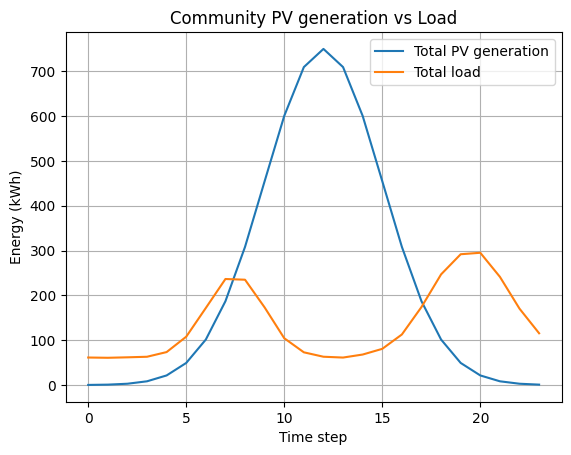

In [6]:
plt.figure()
plt.plot(history["total_pv"], label="Total PV generation")
plt.plot(history["total_load"], label="Total load")
plt.xlabel("Time step")
plt.ylabel("Energy (kWh)")
plt.title("Community PV generation vs Load")
plt.legend()
plt.grid(True)
plt.show()


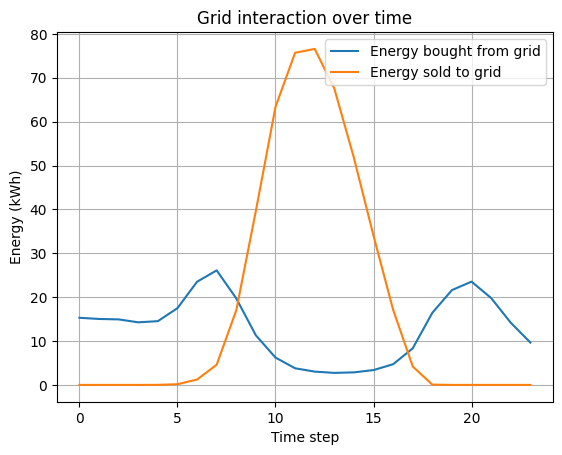

In [7]:
plt.figure()
plt.plot(history["grid_import"], label="Energy bought from grid")
plt.plot(history["grid_export"], label="Energy sold to grid")
plt.xlabel("Time step")
plt.ylabel("Energy (kWh)")
plt.title("Grid interaction over time")
plt.legend()
plt.grid(True)
plt.show()


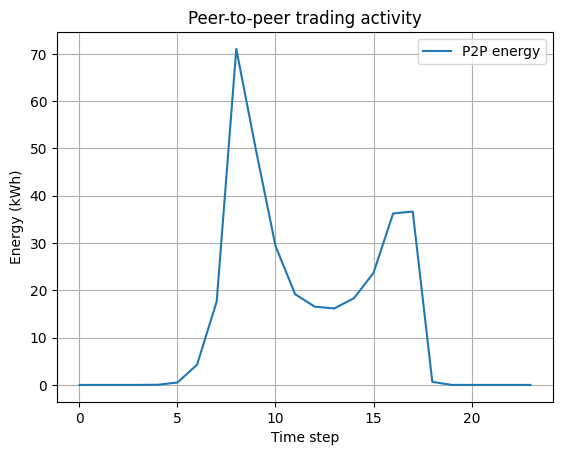

In [8]:
plt.figure()
plt.plot(history["p2p_energy"], label="P2P energy")
plt.xlabel("Time step")
plt.ylabel("Energy (kWh)")
plt.title("Peer-to-peer trading activity")
plt.legend()
plt.grid(True)
plt.show()


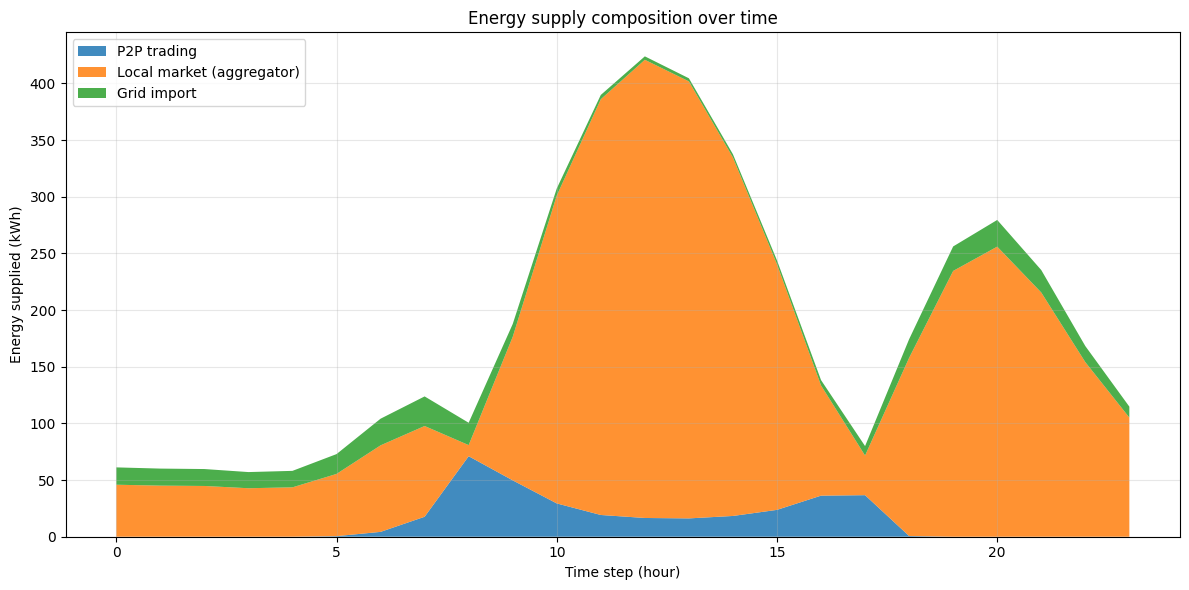

In [9]:
time = np.arange(len(history["total_load"]))

plt.figure(figsize=(12, 6))

plt.stackplot(
    time,
    history["p2p_energy"],
    history["local_energy"],
    history["grid_import"],
    labels=["P2P trading", "Local market (aggregator)", "Grid import"],
    alpha=0.85
)

plt.xlabel("Time step (hour)")
plt.ylabel("Energy supplied (kWh)")
plt.title("Energy supply composition over time")

plt.legend(loc="upper left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


- How is the community demand satisfied over time, and which market layer dominates?

- Night and Early morning :
    No PV
    Almost no P2P 
    Local market dominates 
    we have some energy bought from the grid 

- Morning 6-9:
    PV starts increasing
    some prosumers begin to have surplus 
    p2p trading appears
    Local market still large 

- Midday 10-14:
    PV peak 
    Many sellers but few buyers 
    local market dominates 
    grid import is almost zer0
    p2p shrinks again
=> too much surplus not enough demand so p2p is limited by the lack of buyers so aggregator absorb surplus while grid is avoided 

- Evening Peak (17-21)
    pv drops fast
    load peaks 
    buyers dominate again
    Local market supplies most energy
    grid import increases 
=> stored energy is used first and grid is fall back and p2p only works briefly where overlap exists 



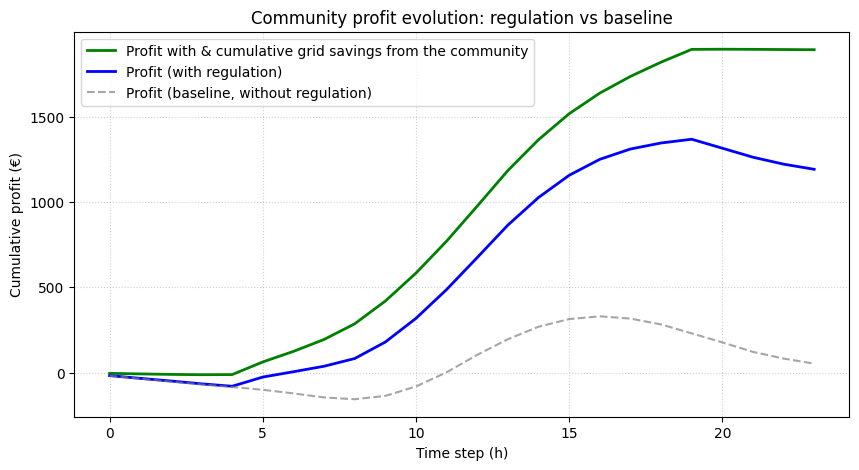

In [10]:
import numpy as np

plt.figure(figsize=(10, 5))

# Collecting necessary data
prices = np.array(results["raw_data"]["grid_price"])
total_load = np.array(history["total_load"])
grid_import = np.array(history["grid_import"])

# Computing hourly savings and cumulative savings
grid_savings_hourly = (total_load - grid_import) * prices
cumulative_savings = np.cumsum(grid_savings_hourly)

# 1. REGULATED CURVE WITH CUMULATIVE GRID SAVINGS
plt.plot(history["community_profit"] + cumulative_savings, 
         label="Profit with & cumulative grid savings from the community", 
         color="green", 
         linewidth=2)


# 2. REGULATED CURVE (HISTORY)
plt.plot(history["community_profit"], 
         label="Profit (with regulation)", 
         color="blue", 
         linewidth=2)

# 3. BASELINE CURVE (HISTORY_BASE)
plt.plot(history_base["community_profit"], 
         label="Profit (baseline, without regulation)", 
         color="gray", 
         linestyle="--", 
         alpha=0.7)

plt.xlabel("Time step (h)")
plt.ylabel("Cumulative profit (€)")
plt.title("Community profit evolution: regulation vs baseline")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

In [11]:
import numpy as np

h = results["history"]

total_p2p = float(np.sum(h["p2p_energy"]))
total_local_in = float(np.sum(h["battery_charge"]))      # local absorption
total_local_out = float(np.sum(h["battery_discharge"]))  # local supply
total_grid_in = float(np.sum(h["grid_import"]))
total_grid_out = float(np.sum(h["grid_export"]))

print("===== TRADING SUMMARY =====")
print(f"P2P traded energy (kWh): {total_p2p:.1f}")

print(f"Local (battery) absorbed (kWh): {total_local_in:.1f}")
print(f"Local (battery) supplied  (kWh): {total_local_out:.1f}")

print(f"Grid import (kWh): {total_grid_in:.1f}")
print(f"Grid export (kWh): {total_grid_out:.1f}")

# Shares (good for slides)
total_supply_to_load = float(np.sum(h["total_load"]))  # approximate denominator
print("\n===== SUPPLY SHARES (rough, for slides) =====")
print(f"P2P / Load: {total_p2p/total_supply_to_load:.2%}")
print(f"Battery discharge / Load: {total_local_out/total_supply_to_load:.2%}")
print(f"Grid import / Load: {total_grid_in/total_supply_to_load:.2%}")


===== TRADING SUMMARY =====
P2P traded energy (kWh): 340.1
Local (battery) absorbed (kWh): 0.0
Local (battery) supplied  (kWh): 0.0
Grid import (kWh): 312.5
Grid export (kWh): 453.0

===== SUPPLY SHARES (rough, for slides) =====
P2P / Load: 10.17%
Battery discharge / Load: 0.00%
Grid import / Load: 9.35%


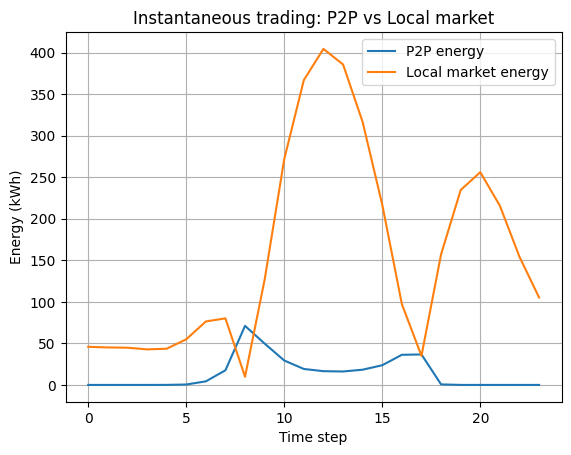

In [12]:
plt.figure()
t = np.arange(len(h["p2p_energy"]))
plt.plot(t, h["p2p_energy"], label="P2P energy")
plt.plot(t, h.get("local_energy", [0]*len(h["p2p_energy"])), label="Local market energy")
plt.xlabel("Time step")
plt.ylabel("Energy (kWh)")
plt.title("Instantaneous trading: P2P vs Local market")
plt.legend()
plt.grid(True)
plt.show()


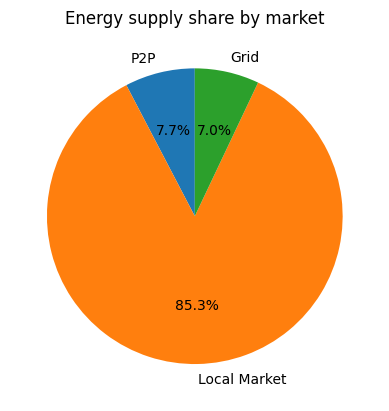

In [13]:
total_p2p = np.sum(h["p2p_energy"])
total_local = np.sum(h["local_energy"])
total_grid = np.sum(h["grid_import"])

plt.figure()
plt.pie(
    [total_p2p, total_local, total_grid],
    labels=["P2P", "Local Market", "Grid"],
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Energy supply share by market")
plt.show()


In [14]:

h = results["history"]
grid_price = results["raw_data"]["grid_price"]

hours = np.arange(len(h["total_load"]))

grid_consumption = np.array(h["grid_import"])
p2p_consumption = np.array(h["p2p_energy"])
local_consumption = np.array(h["local_energy"])
total_consumption = np.array(h["total_load"])

# Approximate P2P price advantage (10% cheaper than grid)
p2p_price = 0.9 * grid_price

financial_benefit = p2p_consumption * (grid_price - p2p_price)


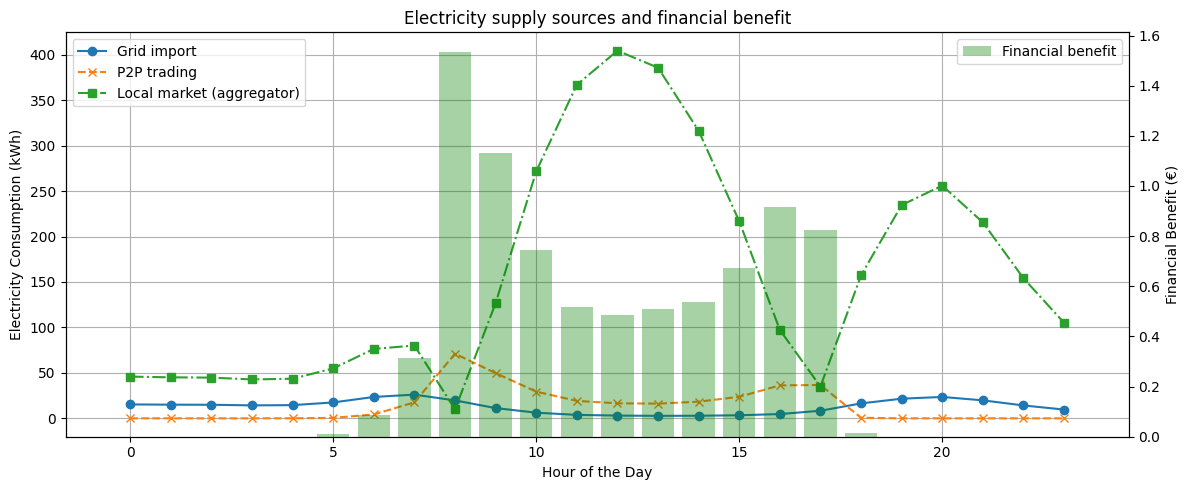

In [15]:
fig, ax1 = plt.subplots(figsize=(12,5))

# Energy components
ax1.plot(hours, grid_consumption, 'o-', label="Grid import")
ax1.plot(hours, p2p_consumption, 'x--', label="P2P trading")
ax1.plot(hours, local_consumption, 's-.', label="Local market (aggregator)")

ax1.set_xlabel("Hour of the Day")
ax1.set_ylabel("Electricity Consumption (kWh)")
ax1.legend(loc="upper left")
ax1.grid(True)

# Financial benefit (right axis)
ax2 = ax1.twinx()
ax2.bar(
    hours,
    financial_benefit,
    alpha=0.35,
    color="green",
    label="Financial benefit"
)
ax2.set_ylabel("Financial Benefit (€)")
ax2.legend(loc="upper right")

plt.title("Electricity supply sources and financial benefit")
plt.tight_layout()
plt.show()


- Grid Import dominates around :
    0-6
    18-23
=> drops close to zero around midday 

- P2P :
    Active only when there is simultanous surplus and dificit 
    peaks around 8-10 and 15-17
    goes to zero when everyone is surplus (midday)
    every one is dificit (night)

- Local market(aggregator)
    dominate energy surplus during midday and evening 
    has much larger volume than p2p 

- financial benefit 
    highest when market activity is high and grid import is low
    drops when grid become dominant again


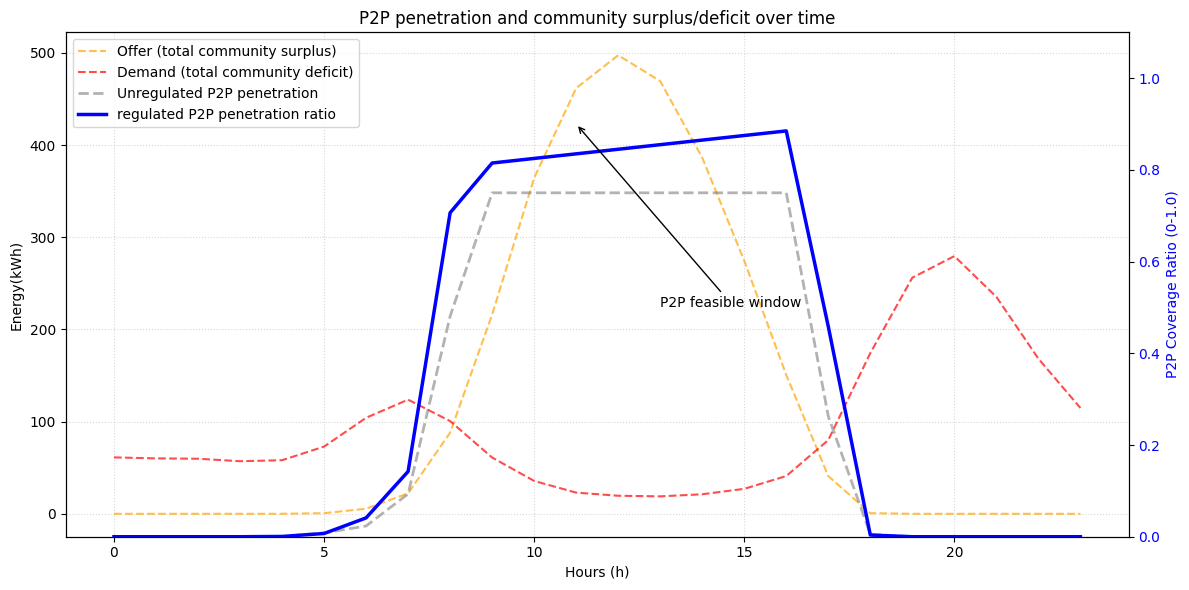

In [16]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

# --- AXIS 1 (Left) : Energy volume kWh ---
ax1.plot(history["total_community_surplus"], label="Offer (total community surplus)", color='orange', linestyle='--', alpha=0.7)
ax1.plot(history["total_community_deficit"], label="Demand (total community deficit)", color='red', linestyle='--', alpha=0.7)
ax1.set_xlabel("Hours (h)")
ax1.set_ylabel("Energy(kWh)", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='both', linestyle=':', alpha=0.5)

# --- AXIS 2 (Right) : Penetration Ratio ---
ax2 = ax1.twinx()  # Create a second y-axis

# 1. BASELINE CURVE (WITHOUT REGULATION)
# We use history_base to show the default behavior
ax2.plot(history_base["P2P_penetration_ratio"], 
         label="Unregulated P2P penetration", 
         color='gray', linestyle='--', linewidth=2, alpha=0.6)

# 2. REGULATED CURVE
ax2.plot(history["P2P_penetration_ratio"], label="regulated P2P penetration ratio", color='blue', linewidth=2.5)
ax2.set_ylabel("P2P Coverage Ratio (0-1.0)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(0, 1.1)
ax2.annotate(
    "P2P feasible window",
    xy=(11, 0.9),
    xytext=(13, 0.5),
    arrowprops=dict(arrowstyle="->")
)


# Récupération des limites actuelles du graphique pour couvrir toute la hauteur
y_max = ax1.get_ylim()[1]

# Conversion into numpy arrays for easier manipulation
deficits = np.array(history["total_community_deficit"])

"""
# Add a colored zone for the "Saturation Zone" at noon
# To highlight the moment when the deficit is zero
import numpy as np
deficits = np.array(history["total_community_deficit"])
ax1.fill_between(range(len(deficits)), 0, max(history["total_community_surplus"]), 
                 where=(deficits < 1e-6), color='yellow', alpha=0.1, label="Saturation (No Demand)")
"""
                 
# Title and legends
plt.title("P2P penetration and community surplus/deficit over time")
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

regulator does not create energy, but improves matching efficiency 

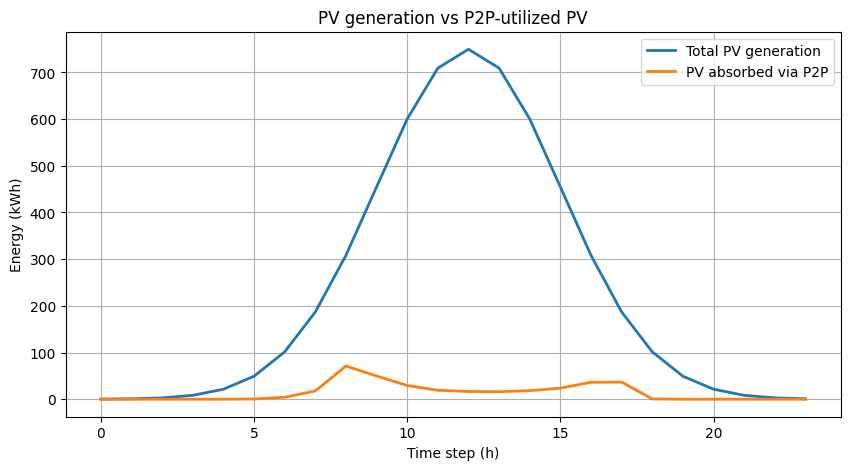

In [17]:
plt.figure(figsize=(10,5))
plt.plot(h["total_pv"], label="Total PV generation", linewidth=2)
plt.plot(h["p2p_energy"], label="PV absorbed via P2P", linewidth=2)
plt.xlabel("Time step (h)")
plt.ylabel("Energy (kWh)")
plt.title("PV generation vs P2P-utilized PV")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
res_reg = run_simulation(activate_regulator=True)
res_no  = run_simulation(activate_regulator=False)

hR = res_reg["history"]
hN = res_no["history"]


>>> NEW DOUBLE-PEAK LOAD PROFILE USED <<<
Left after P2P - Sellers: 0, Buyers: 200
Left after P2P - Sellers: 0, Buyers: 200
Left after P2P - Sellers: 0, Buyers: 200
Left after P2P - Sellers: 0, Buyers: 200
Left after P2P - Sellers: 0, Buyers: 199
Left after P2P - Sellers: 0, Buyers: 189
Left after P2P - Sellers: 0, Buyers: 171
Left after P2P - Sellers: 0, Buyers: 133
Left after P2P - Sellers: 0, Buyers: 38
Left after P2P - Sellers: 75, Buyers: 0
Left after P2P - Sellers: 116, Buyers: 0
Left after P2P - Sellers: 129, Buyers: 0
Left after P2P - Sellers: 131, Buyers: 0
Left after P2P - Sellers: 131, Buyers: 0
Left after P2P - Sellers: 129, Buyers: 0
Left after P2P - Sellers: 117, Buyers: 0
Left after P2P - Sellers: 78, Buyers: 0
Left after P2P - Sellers: 0, Buyers: 68
Left after P2P - Sellers: 0, Buyers: 191
Left after P2P - Sellers: 0, Buyers: 200
Left after P2P - Sellers: 0, Buyers: 200
Left after P2P - Sellers: 0, Buyers: 200
Left after P2P - Sellers: 0, Buyers: 200
Left after P2P - Se

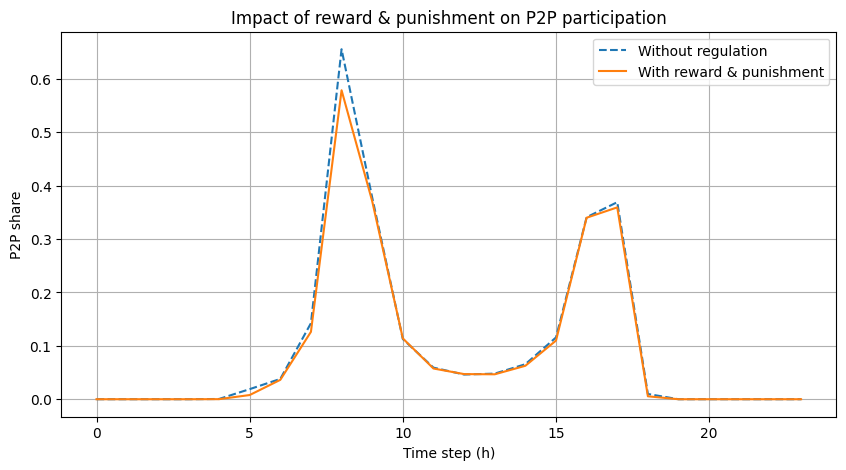

In [19]:
plt.figure(figsize=(10,5))
plt.plot(hN["p2p_share"], '--', label="Without regulation")
plt.plot(hR["p2p_share"], label="With reward & punishment")
plt.xlabel("Time step (h)")
plt.ylabel("P2P share")
plt.title("Impact of reward & punishment on P2P participation")
plt.legend()
plt.grid(True)
plt.show()
